In [60]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [61]:
# Function to compute Euclidean distance using PyTorch
def euclidean_distance_gpu(a, b):
    a = a.unsqueeze(1)  # Shape: (n_samples, 1, n_features)
    b = b.unsqueeze(0)  # Shape: (1, n_clusters, n_features)
    return torch.sum((a - b) ** 2, dim=2)

# K-means algorithm using PyTorch
def run_kmeans_gpu(data, k, max_iter=500):
    # Initialize centroids randomly
    centroids = data[torch.randperm(data.shape[0])[:k]]

    for _ in tqdm(range(max_iter), desc="Running k-means"):
        # Compute distances and assign labels
        distances = euclidean_distance_gpu(data, centroids)
        labels = torch.argmin(distances, dim=1)

        # Compute new centroids
        new_centroids = torch.stack([
            data[labels == i].mean(dim=0) if (labels == i).sum() > 0 else centroids[i]
            for i in range(k)
        ])

        # Check for convergence
        if torch.allclose(new_centroids, centroids, atol=1e-8):
            print("K-means converged.")
            break

        centroids = new_centroids

    return centroids.cpu().numpy(), labels.cpu().numpy()

# Visualization function
def visualize_clusters(centroids, labels, data, k, num_samples=5):
    # Plot centroids
    plt.figure(figsize=(10, 2))
    for i in range(k):
        plt.subplot(1, k, i + 1)
        plt.imshow(centroids[i].reshape(28, 28), cmap="gray")
        plt.title(f"Centroid {i+1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Plot sample images for each cluster
    plt.figure(figsize=(8, 1.5 * k))
    for cluster_id in range(k):
        cluster_indices = np.where(labels == cluster_id)[0]
        sampled_indices = np.random.choice(
            cluster_indices, min(len(cluster_indices), num_samples), replace=False
        )
        # Add a label at the top of the row
        plt.subplot(k, num_samples, cluster_id * num_samples + 1)
        plt.text(-20, 14, f"Cluster {cluster_id + 1}", fontsize=12, va="center")
        plt.axis("off")
        for j, idx in enumerate(sampled_indices):
            plt.subplot(k, num_samples, cluster_id * num_samples + j + 1)
            plt.imshow(data[idx].reshape(28, 28), cmap="gray")
            plt.axis("off")
            plt.tight_layout()
    plt.show()

In [62]:
# Load MNIST dataset using torchvision
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Convert the dataset to NumPy arrays
x_train = mnist_dataset.data.numpy()
y_train = mnist_dataset.targets.numpy()

# Load the test dataset similarly
mnist_test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
x_test = mnist_test_dataset.data.numpy()
y_test = mnist_test_dataset.targets.numpy()

# Merge training and test datasets
x = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

Shape of the first image: torch.Size([784])
Running k-means with k=3...


Running k-means:   0%|          | 0/500 [00:00<?, ?it/s]

K-means converged.


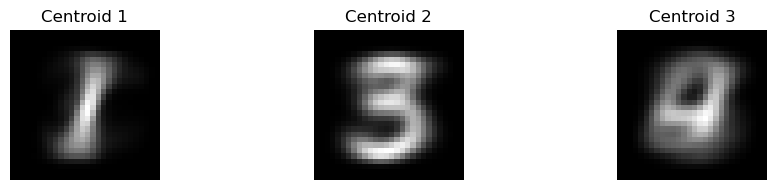

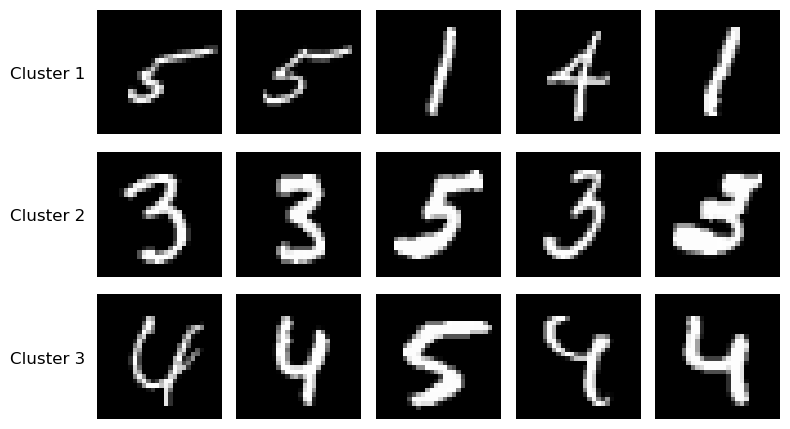

Finished k-means with k=3.

Running k-means with k=4...


Running k-means:   0%|          | 0/500 [00:00<?, ?it/s]

K-means converged.


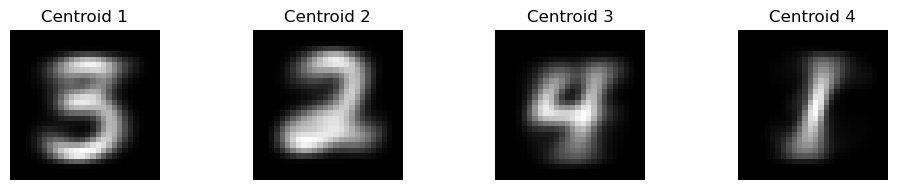

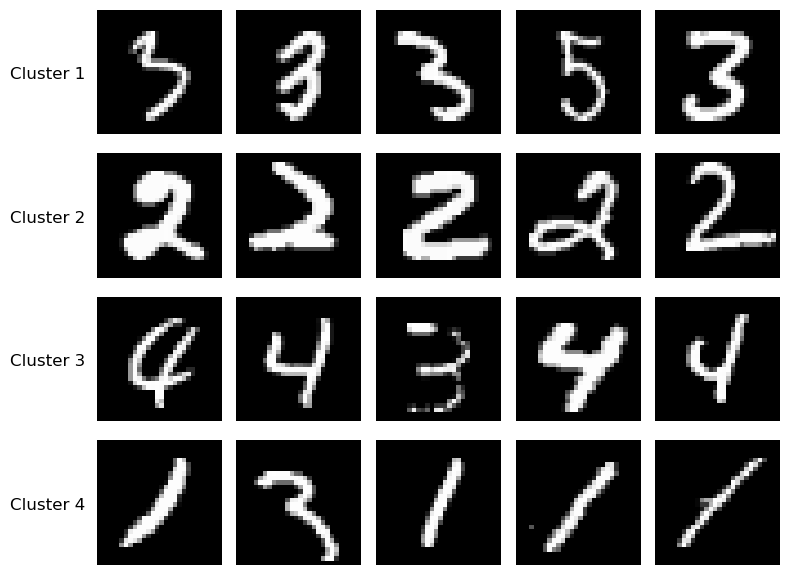

Finished k-means with k=4.

Running k-means with k=5...


Running k-means:   0%|          | 0/500 [00:00<?, ?it/s]

K-means converged.


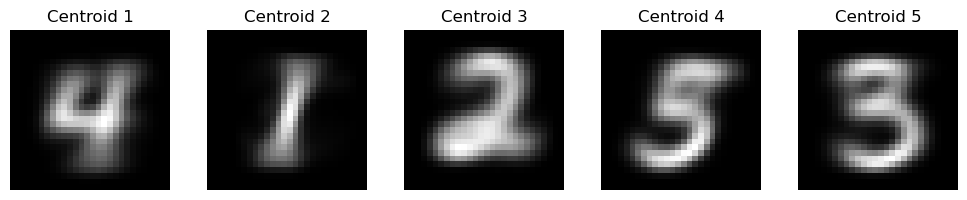

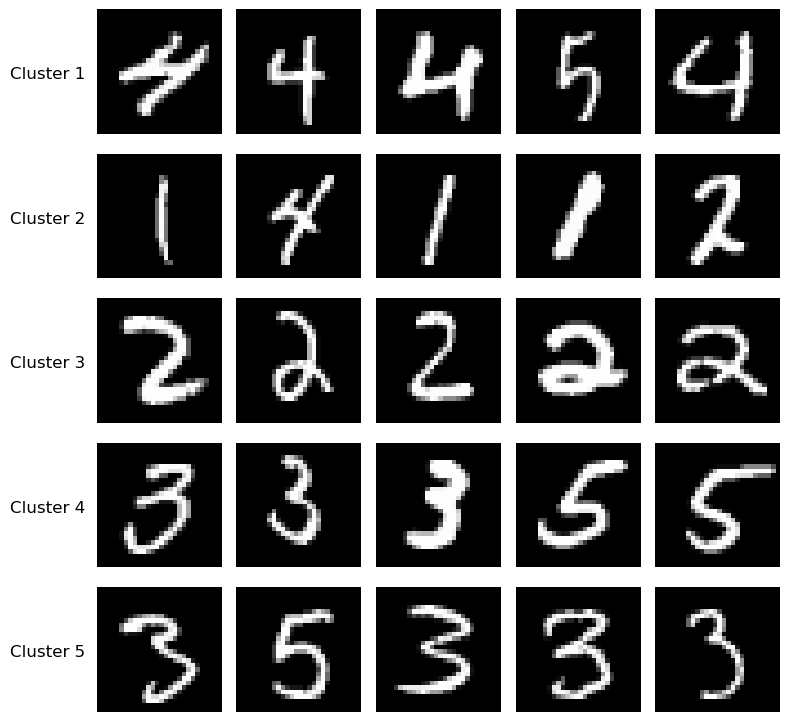

Finished k-means with k=5.

Running k-means with k=6...


Running k-means:   0%|          | 0/500 [00:00<?, ?it/s]

K-means converged.


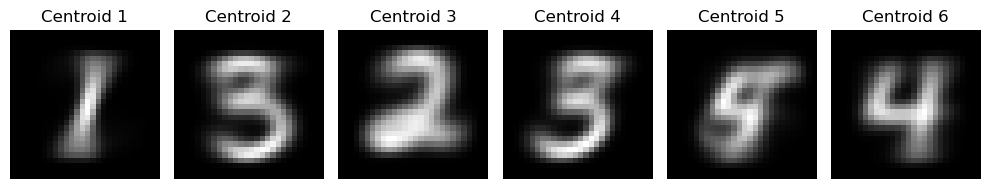

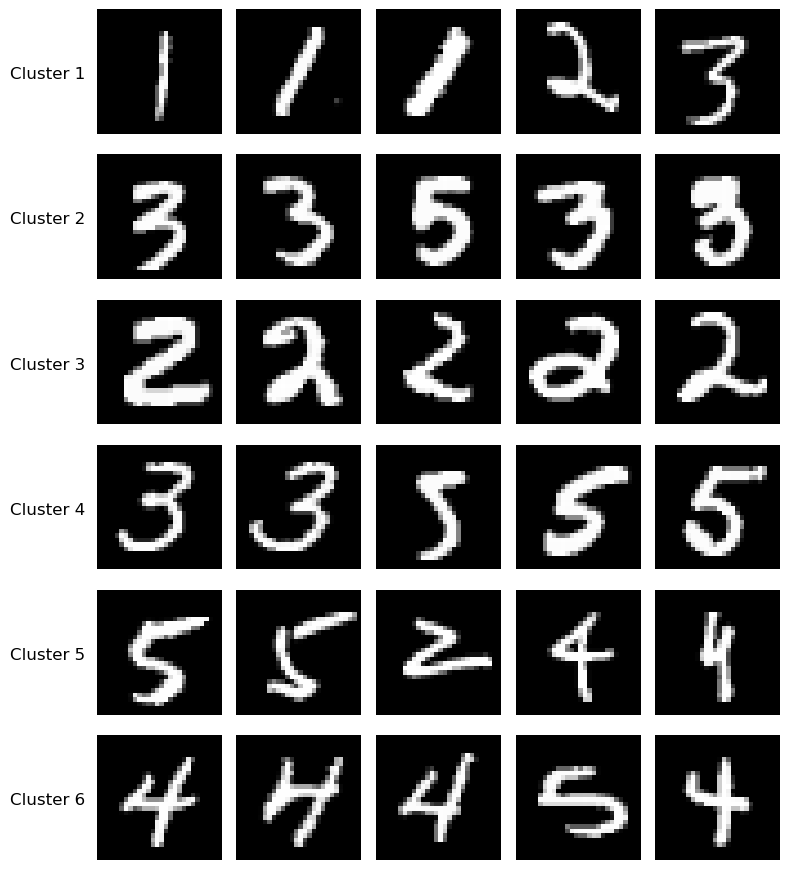

Finished k-means with k=6.



In [63]:
# Filter images of digits 1 to 5
indices = np.where((y >= 1) & (y <= 5))[0]
x = x[indices]
y = y[indices]

# Flatten images
x_flattened = x.reshape(-1, 28 * 28)

# Convert to float32 and normalize
x_normalized = torch.tensor(x_flattened, dtype=torch.float32) / 255.0
print(f"Shape of the first image: {x_normalized[0].shape}")

# Test K-means with multiple cluster sizes
k_to_test = [3, 4, 5, 6]
for k in k_to_test:
    print(f"Running k-means with k={k}...")
    centroids, labels = run_kmeans_gpu(x_normalized.cuda(), k)
    visualize_clusters(centroids, labels, x, k)
    print(f"Finished k-means with k={k}.")
    print("")
